In [1]:
from casadi import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def timecrossings(arr, times, pos):
    crossings = []
    sign_arr = sign(arr)
    for ii in range(1,len(arr)):
        if sign_arr[ii-1] != sign_arr[ii]:
            if cos(pos[ii]) > -0.99 :
                crossings.append((times[ii-1] + times[ii])/2)
    return crossings

In [3]:
def plot_results(sol, max_par, N):
    arr = sol.value(X)
    timescale_x = np.linspace(0, sol.value(T), N+1)
    timescale_u = np.linspace(0, sol.value(T), N)
    arr_u = sol.value(U)
    plt.figure(figsize=[10,7])
    plt.plot(timescale_x,arr[:,0], label = '$x$')
    plt.plot(timescale_x,arr[:,1], label = "$x'$")
    plt.plot(timescale_u,arr_u[:], label = 'u')
    plt.plot(timescale_x,2+cos(arr[:,0]),':', label = '$2+cos(x)$')
    cross_points = timecrossings(arr[:,1], timescale_x, arr[:,0])
    plt.hlines([0,pi, -pi], 0, timescale_u[-1], 'k', 'dotted')
    plt.hlines([-max_par,max_par], 0, timescale_u[-1], 'r', 'dotted')
    plt.vlines(cross_points, -pi, pi, 'k', 'dotted')
    print(f'Max par: {max_par}, number of crossing points: {len(cross_points)}')
    plt.legend()

## Pendulum exercise
$$
\begin{split}\begin{array}{lc}
\begin{array}{l}
\text{minimize:} \\
x(\cdot) \in \mathbb{R}^2, \, u(\cdot) \in \mathbb{R}
\end{array}
\quad \displaystyle \int_{t=0}^{T}{cos(x_0) \, dt}
\\
\\
\text{subject to:} \\
\\
\begin{array}{ll}
\left\{
\begin{array}{l}
\dot{x}_0 = x_1 \\
\dot{x}_1 = u - sin(x_0) \\
-u_{max} \le u \le u_{max} , \quad
\end{array} \right. & \text{for} \, 0 \le t \le T \\
x_0(0)=0, \quad x_1(0)=0, x_0(T) = pi/2 , x_1(T) = 0
\end{array}
\end{array}\end{split}
$$
with $T=10$.

siendo $$x_0 = \theta$$ $$x_1 = \theta'$$

In [4]:
x = MX.sym('x', 2)
t = MX.sym('t')
dt = MX.sym('dt')
u = MX.sym('u')

In [5]:
rhs = vertcat(x[1], u-sin(x[0]))
#rhs = vertcat(x[1], u)
F = Function('F', [x, u], [rhs])

k1 = F(x, u);
k2 = F(x + dt/2 * k1, u)
k3 = F(x + dt/2 * k2, u)
k4 = F(x + dt * k3, u);
new_x_expr = x+dt/6*(k1 +2*k2 +2*k3 +k4)

In [6]:
new_x_expr = x + dt * F(x, u)
new_x = Function('New_x', [x, u, dt], [new_x_expr])

In [7]:
F([0,1],2)

DM([1, 2])

In [8]:
new_x([0,1],2,0.1)

DM([0.1, 1.2])

In [9]:
N = 200

In [10]:
opti = Opti()
opti.solver('ipopt')

In [11]:
X = opti.variable(N+1,2)
U = opti.variable(N)
T = opti.variable()
u_m = opti.parameter()
#t_m = opti.parameter()

In [12]:
cost = sum1(2+cos(X[:,0]))*T #**2
#cost = -sum1(X[:,0])
opti.minimize(cost)

In [13]:
opti.subject_to(X[0,:].T == [0, 0])
opti.subject_to(cos(X[-1,0]) < -0.9999)
#opti.subject_to(T < t_m)
opti.subject_to(opti.bounded(-0.001,X[-1,1],0.001))

arr[3,:], new_x(arr[2,:])

In [14]:
for ii in range(N):
    opti.subject_to(X[ii+1,:].T == new_x(X[ii,:], U[ii], T/N))
    opti.subject_to(opti.bounded(-u_m,U[ii],u_m))

In [15]:
opti.set_initial(X[:,0], np.linspace(0, pi, N+1))
opti.set_initial(X[:,1], pi/N)
opti.set_initial(T, 50)

In [16]:
max_par = 0.1
opti.set_value(u_m, max_par)

In [17]:
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1802
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:      802

Total number of variables............................:      603
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Max par: 0.1, number of crossing points: 5


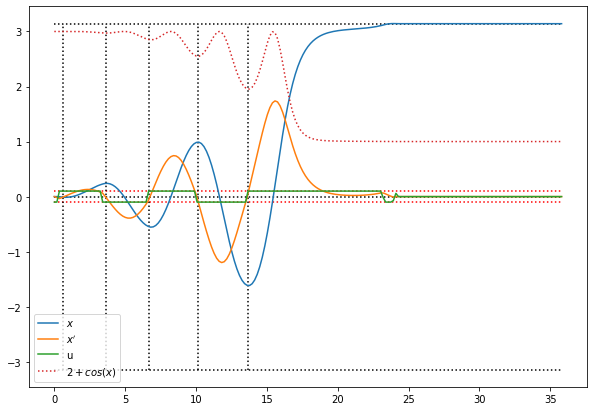

In [18]:
plot_results(sol, max_par, N)

In [19]:
results = []
for ii in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
    opti.set_value(u_m, ii)
    est_t = (2 + sqrt(1/ii))*8
    opti.set_initial(T, est_t)
    try:
        sol = opti.solve()
    except:
        pass
    else:
        results.append([sol, ii, N])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1802
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:      802

Total number of variables............................:      603
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      402
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      201
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  24  9.2893221e+03 6.87e-04 2.80e+02  -1.0 8.58e-01   1.0 4.85e-01 1.59e-01f  1
  25  9.2608120e+03 6.74e-04 2.63e+02  -1.0 2.31e+00   0.5 6.35e-02 6.37e-02f  1
  26  9.1986234e+03 1.16e-03 1.58e+02  -1.0 7.53e-01   0.9 7.09e-01 4.52e-01f  1
  27  9.1843163e+03 1.33e-03 1.55e+02  -1.0 5.75e+00   0.4 5.92e-03 2.26e-02f  1
  28  9.1505589e+03 1.38e-03 8.97e+01  -1.0 6.49e-01   0.9 7.35e-01 3.77e-01f  1
  29  9.1183146e+03 2.44e-03 8.80e+01  -1.0 7.22e+00   0.4 3.37e-03 4.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.1100566e+03 2.25e-03 5.86e+01  -1.0 4.95e-01   0.8 6.33e-01 8.83e-02f  1
  31  9.0845908e+03 2.67e-03 5.47e+01  -1.0 3.85e+00   0.3 6.24e-03 9.90e-02f  1
  32  9.0586836e+03 2.06e-03 3.95e+01  -1.0 3.95e-01    -  2.81e-01 2.75e-01f  1
  33  9.0168835e+03 2.33e-03 2.42e+01  -1.0 6.03e-01   0.8 3.68e-01 6.14e-01f  1
  34  8.9905529e+03 4.56e-04 3.38e+00  -1.0 2.22e-01   1.2 1.00e+00 1.00e+00f  1
  35  8.9763841e+03 5.56e-04

 124  7.6327799e+03 5.73e-04 4.38e+01  -1.7 6.44e-01   0.5 8.80e-02 5.84e-01f  1
 125  7.6279378e+03 3.67e-04 3.68e+00  -1.7 2.23e-01   0.9 6.02e-01 4.01e-01f  1
 126  7.6232869e+03 3.58e-04 1.22e+01  -1.7 9.90e-01   0.5 2.24e-01 1.08e-01f  1
 127  7.6135199e+03 1.48e-04 1.42e+00  -1.7 1.84e-01   0.9 1.00e+00 9.96e-01f  1
 128  7.5986580e+03 4.66e-04 2.17e+01  -1.7 5.72e-01   0.4 7.35e-02 3.45e-01f  1
 129  7.5958685e+03 3.67e-04 1.49e+00  -1.7 1.94e-01   0.8 5.01e-01 2.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  7.5872857e+03 4.53e-04 3.66e+01  -1.7 1.64e+00   0.4 2.18e-01 1.14e-01f  1
 131  7.5793425e+03 2.72e-04 3.45e+01  -1.7 3.32e-01   0.8 6.69e-01 5.51e-01f  1
 132  7.5712623e+03 4.30e-04 1.91e+01  -1.7 2.22e+00   0.3 1.93e-02 1.09e-01f  1
 133  7.5628404e+03 3.22e-04 4.36e+01  -1.7 2.95e-01   0.7 7.58e-01 4.63e-01f  1
 134  7.5593447e+03 3.19e-04 4.70e+01  -1.7 1.04e+00   0.3 1.20e-01 6.39e-02f  1
 135  7.5463523e+03 3.20e-04

  15  1.3348473e+04 1.88e-02 5.82e+01  -1.0 9.90e-01   1.6 2.48e-01 1.04e-01f  1
  16  1.3310420e+04 1.47e-02 5.17e+01  -1.0 2.82e-01   2.1 2.04e-01 2.40e-01f  1
  17  1.3242784e+04 1.30e-02 5.35e+01  -1.0 1.17e+00   1.6 3.12e-01 1.19e-01f  1
  18  1.3223338e+04 1.11e-02 1.92e+02  -1.0 2.12e-01   2.0 6.84e-01 1.53e-01f  1
  19  1.3167091e+04 9.84e-03 1.79e+02  -1.0 1.01e+00   1.5 1.84e-01 1.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3152076e+04 8.30e-03 2.08e+02  -1.0 2.21e-01   2.0 3.68e-01 1.62e-01f  1
  21  1.3133553e+04 7.75e-03 2.04e+02  -1.0 5.62e-01   1.5 2.18e-01 6.80e-02f  1
  22  1.3140082e+04 4.90e-03 2.74e+02  -1.0 2.33e-01   1.9 1.00e+00 3.91e-01h  1
  23  1.3131774e+04 4.28e-03 2.36e+02  -1.0 5.96e-01   1.4 1.62e-01 1.28e-01f  1
  24  1.3158055e+04 3.28e-03 1.70e+02  -1.0 4.18e-01   1.9 1.67e-01 2.38e-01h  1
  25  1.3146827e+04 2.68e-03 2.11e+02  -1.0 8.60e-01   1.4 3.44e-01 1.85e-01f  1
  26  1.3150282e+04 2.57e-03

  41  1.6782171e+04 3.49e-03 6.78e+01  -1.0 5.34e-01    -  5.13e-02 1.66e-01f  1
  42  1.6775017e+04 2.56e-03 4.36e+01  -1.0 1.38e-01    -  2.98e-01 2.82e-01f  1
  43  1.6763176e+04 2.11e-03 6.09e+01  -1.0 1.87e-01   1.0 1.00e+00 5.91e-01f  1
  44  1.6750414e+04 1.49e-03 2.95e+01  -1.0 1.70e-01    -  4.10e-01 3.87e-01f  1
  45  1.6735982e+04 4.14e-03 7.40e+01  -1.0 2.37e+00   0.6 7.87e-03 7.76e-02f  1
  46  1.6734451e+04 4.12e-03 9.63e+01  -1.0 1.56e+00    -  4.60e-02 8.06e-03h  1
  47  1.6725891e+04 4.23e-03 7.04e+01  -1.0 9.16e-01    -  2.86e-02 7.54e-02f  1
  48  1.6716323e+04 3.52e-03 7.76e+00  -1.0 2.67e-01   1.0 6.04e-01 2.96e-01f  1
  49  1.6711429e+04 3.35e-03 5.01e+01  -1.0 4.31e-01    -  2.16e-01 6.52e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.6684115e+04 6.92e-03 7.94e+01  -1.0 7.84e-01   0.5 2.29e-01 3.09e-01f  1
  51  1.6679459e+04 5.54e-03 7.59e+01  -1.0 3.32e-01   0.9 3.57e-01 2.27e-01f  1
  52  1.6669117e+04 6.47e-03

 157  1.5995109e+04 1.57e-03 4.40e+01  -2.5 5.10e-01   0.8 5.95e-02 7.80e-02f  1
 158  1.5992627e+04 1.16e-03 3.59e+01  -2.5 1.29e-01   1.3 1.00e+00 2.76e-01f  1
 159  1.5990465e+04 8.50e-04 1.20e+01  -2.5 5.14e-02    -  4.92e-01 2.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.5988580e+04 7.67e-04 1.08e+01  -2.5 3.45e-01   0.8 1.04e-02 2.87e-01f  1
 161  1.5987109e+04 2.83e-04 5.45e-01  -2.5 5.11e-02    -  6.76e-01 6.35e-01f  1
 162  1.5985175e+04 8.83e-05 5.95e-01  -2.5 3.40e-02   1.2 1.00e+00 1.00e+00f  1
 163  1.5983419e+04 1.76e-04 3.06e+00  -2.5 9.74e-01    -  2.64e-02 3.59e-02f  1
 164  1.5981016e+04 2.64e-04 4.12e+01  -2.5 6.41e-01   0.7 1.41e-01 6.23e-02f  1
 165  1.5980374e+04 7.50e-08 2.34e-02  -2.5 5.76e-03    -  1.00e+00 1.00e+00f  1
 166  1.5980076e+04 1.71e-05 3.57e+00  -2.5 1.65e-02    -  1.12e-01 9.13e-01f  1
 167  1.5980026e+04 5.33e-06 1.22e-01  -2.5 8.39e-03   1.2 1.00e+00 1.00e+00f  1
 168  1.5977253e+04 6.09e-04

  33  2.6598011e+04 2.08e-02 2.44e+02  -1.0 5.83e-01   2.1 4.81e-01 1.83e-01f  1
  34  2.6541542e+04 1.34e-02 1.72e+02  -1.0 1.76e-01   2.5 4.48e-01 3.87e-01f  1
  35  2.6422523e+04 9.33e-03 1.58e+02  -1.0 7.45e-01   2.0 5.35e-01 3.38e-01f  1
  36  2.6352681e+04 4.97e-03 7.20e+01  -1.0 2.41e-01   2.5 3.39e-01 5.00e-01f  1
  37  2.6202692e+04 3.10e-03 7.48e+01  -1.0 8.79e-01   2.0 4.61e-01 4.07e-01f  1
  38  2.5982199e+04 2.77e-03 7.70e+01  -1.0 2.72e+00   1.5 3.78e-01 1.94e-01f  1
  39  2.5783794e+04 1.66e-03 8.02e+01  -1.0 9.82e-01   1.9 5.50e-01 4.83e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.5449986e+04 1.80e-03 8.11e+01  -1.0 2.96e+00   1.5 5.04e-01 2.76e-01f  1
  41  2.3976723e+04 2.62e-02 8.27e+01  -1.0 9.35e+00   1.0 3.07e-01 3.59e-01f  1
  42  2.3655973e+04 1.94e-02 8.04e+01  -1.0 2.99e+00   1.4 2.85e-01 2.77e-01f  1
  43  2.3119124e+04 1.84e-02 8.06e+01  -1.0 9.93e+00   0.9 1.10e-01 1.36e-01f  1
  44  2.2874820e+04 1.49e-02

   7  3.8455751e+04 4.64e-01 2.19e+02  -1.0 8.18e+00   2.7 4.47e-03 2.30e-03f  1
   8  3.8447556e+04 4.63e-01 4.76e+02  -1.0 8.70e+00   3.2 6.11e-03 1.47e-03h  1
   9  3.8422127e+04 4.61e-01 4.14e+02  -1.0 7.29e+00   2.7 6.71e-04 5.93e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8410171e+04 4.59e-01 7.61e+02  -1.0 6.86e+00   3.1 1.21e-02 2.42e-03f  1
  11  3.8397105e+04 4.57e-01 7.50e+02  -1.0 7.20e+00   2.6 3.94e-03 5.20e-03f  1
  12  3.8395809e+04 4.57e-01 9.68e+02  -1.0 5.73e+00   3.1 8.13e-03 2.55e-04h  1
  13  3.8393447e+04 4.55e-01 9.49e+02  -1.0 8.53e+00   2.6 1.02e-04 3.64e-03f  1
  14  3.8391526e+04 4.55e-01 1.19e+03  -1.0 5.51e+00   3.0 1.33e-02 4.55e-04h  1
  15  3.8341188e+04 4.50e-01 5.97e+02  -1.0 5.83e+00   3.4 1.90e-03 1.08e-02f  1
  16  3.8340066e+04 4.50e-01 8.41e+02  -1.0 5.24e+00   3.0 2.70e-02 3.45e-04h  1
  17  3.8272711e+04 4.43e-01 5.80e+02  -1.0 4.79e+00   3.4 1.23e-03 1.47e-02f  1
  18  3.8272108e+04 4.43e-01

 111  2.2980119e+04 2.03e-02 4.40e+02  -1.0 2.38e+00   0.5 2.70e-01 3.38e-02f  1
 112  2.2988620e+04 1.90e-02 2.36e+02  -1.0 3.14e-01    -  1.20e-01 6.55e-02h  1
 113  2.3022521e+04 1.51e-02 4.96e+02  -1.0 4.96e-01    -  8.47e-02 2.07e-01h  1
 114  2.3033341e+04 1.40e-02 4.44e+02  -1.0 4.67e-01   0.9 1.41e-01 8.72e-02h  1
 115  2.3081418e+04 9.27e-03 3.02e+02  -1.0 2.75e-01   1.4 5.39e-01 3.83e-01h  1
 116  2.3081720e+04 9.10e-03 2.81e+02  -1.0 4.74e-01   0.9 1.41e-01 1.96e-02h  1
 117  2.3096511e+04 6.92e-03 1.14e+03  -1.0 2.04e-01    -  7.86e-01 2.44e-01h  1
 118  2.3100227e+04 7.26e-03 1.22e+03  -1.0 1.16e+00   0.4 5.44e-03 6.94e-02h  3
 119  2.3115477e+04 9.91e-03 1.54e+02  -1.0 4.74e-01   0.8 7.47e-01 4.60e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.3111402e+04 1.02e-02 1.51e+02  -1.0 1.69e+01   0.3 2.38e-03 2.89e-03f  2
 121  2.3105312e+04 9.66e-03 4.30e+02  -1.0 6.06e-01   0.8 9.84e-01 1.52e-01f  1
 122  2.3103262e+04 9.66e-03

Max par: 0.5, number of crossing points: 2
Max par: 0.2, number of crossing points: 3
Max par: 0.1, number of crossing points: 5
Max par: 0.05, number of crossing points: 7
Max par: 0.02, number of crossing points: 7
Max par: 0.01, number of crossing points: 8


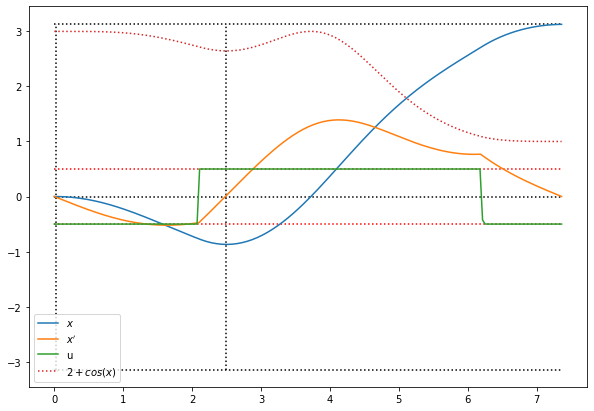

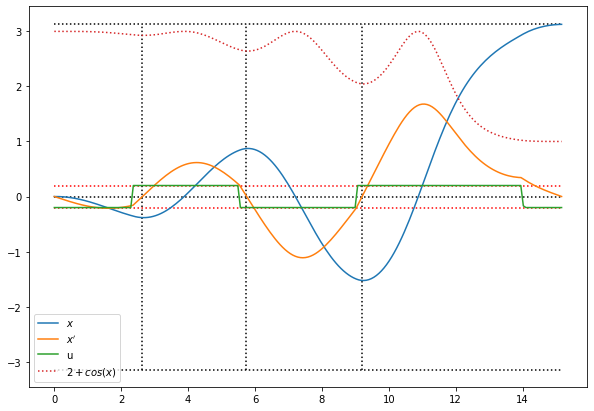

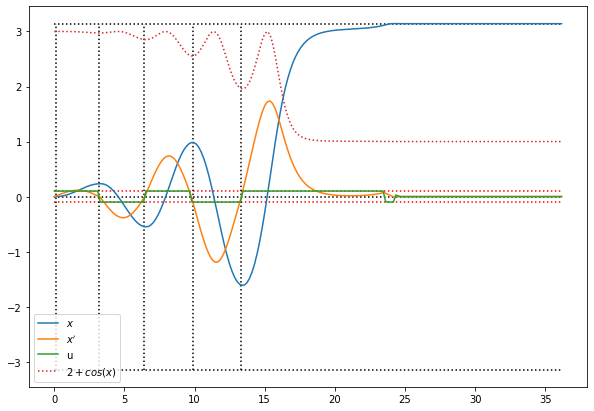

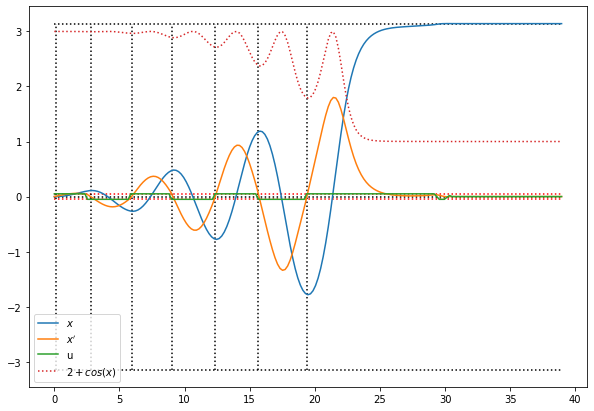

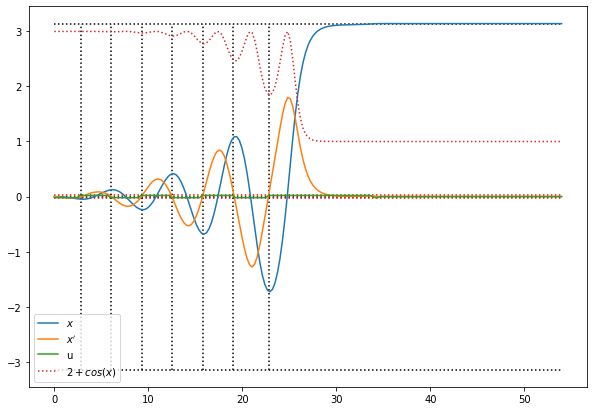

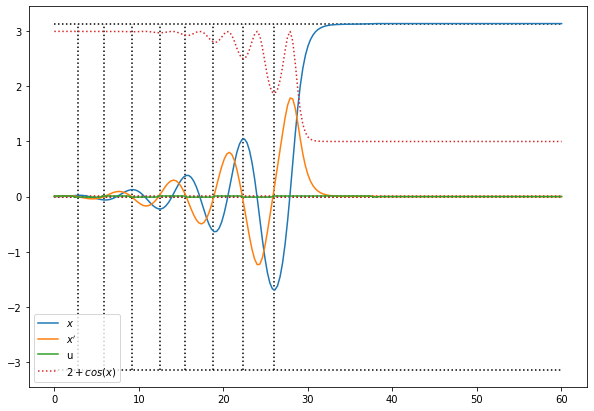

In [20]:
for res in results:
    plot_results(*res)

In [21]:
xx = np.array([1,0.5, 0.2, 0.1, 0.05, 0.02])
yy = np.array([1,2,3,5,6,8])

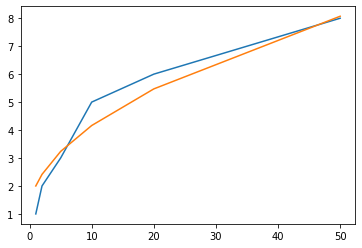

In [22]:
plt.plot(1/xx,yy)
#pp = np.arange(50)
pp = 1/xx
plt.plot(pp,1 + np.sqrt(pp))

## Animation

In [25]:
from matplotlib import animation, rc
from IPython.display import HTML

In [33]:
sol.value(X)

array([[ 6.43043003e-38,  1.89752637e-37],
       [-4.22317366e-38,  3.00181770e-03],
       [ 9.01090052e-04,  6.00363541e-03],
       [ 2.70327016e-03,  8.73496261e-03],
       [ 5.32534408e-03,  1.09253097e-02],
       [ 8.60491960e-03,  1.23285653e-02],
       [ 1.23057265e-02,  1.27473775e-02],
       [ 1.61322530e-02,  1.20553374e-02],
       [ 1.97510419e-02,  1.02147617e-02],
       [ 2.28173241e-02,  1.28443269e-03],
       [ 2.32028870e-02, -8.56612859e-03],
       [ 2.06314939e-02, -1.85323981e-02],
       [ 1.50684114e-02, -2.77269686e-02],
       [ 6.74528920e-03, -3.52518730e-02],
       [-3.83666987e-03, -4.02784862e-02],
       [-1.59275251e-02, -4.21286095e-02],
       [-2.85737530e-02, -4.03494815e-02],
       [-4.06859197e-02, -3.47751551e-02],
       [-5.11247769e-02, -2.55671828e-02],
       [-5.87995714e-02, -1.32289744e-02],
       [-6.27706644e-02,  7.41321608e-03],
       [-6.05453543e-02,  2.92452528e-02],
       [-5.17664713e-02,  5.04105621e-02],
       [-3.

In [34]:
sol.value(U)

array([ 1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000100e-02,
        1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000100e-02,
       -1.00000099e-02, -1.00000100e-02, -1.00000100e-02, -1.00000100e-02,
       -1.00000100e-02, -1.00000100e-02, -1.00000100e-02, -1.00000100e-02,
       -1.00000100e-02, -1.00000100e-02, -1.00000100e-02,  1.00000100e-02,
        1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000100e-02,
        1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000100e-02,
        1.00000100e-02,  1.00000100e-02, -1.00000100e-02, -1.00000100e-02,
       -1.00000100e-02, -1.00000100e-02, -1.00000100e-02, -1.00000100e-02,
       -1.00000100e-02, -1.00000100e-02, -1.00000100e-02, -1.00000100e-02,
       -1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000100e-02,
        1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000100e-02,
        1.00000100e-02,  1.00000100e-02,  1.00000100e-02,  1.00000099e-02,
       -1.00000100e-02, -

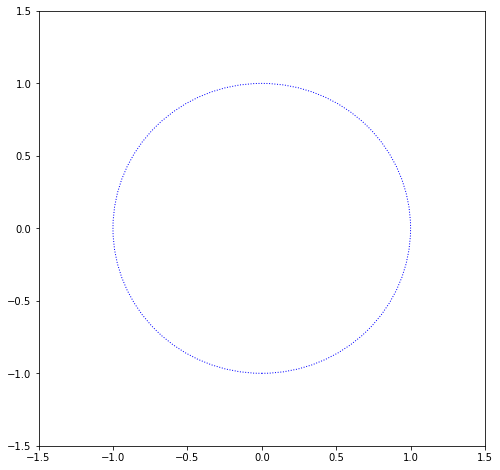

In [77]:
fig, ax = plt.subplots()

fig.set_size_inches([8,8])
ax.set_xlim(( -1.5, 1.5))
ax.set_ylim(( -1.5, 1.5))

circle2 = plt.Circle((0, 0), 1, color='b', ls = ":", fill=False)
ax.add_artist(circle2)

line, = ax.plot([], [], lw=2)
point, = ax.plot([], [], marker='o', markersize=15, color="red")
text = ax.text(0.2, 0, "", fontsize = 12)

In [78]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    text.set_text('')
    return (line,)

In [79]:
def animate(i):
    x = [0, np.sin(sol.value(X)[i,0])]
    y = [0, -np.cos(sol.value(X)[i,0])]
    line.set_data(x, y)    
    point.set_data(x[1], y[1])
    text.set_text("U = %.6f" % sol.value(U)[i])
    return (line,)

In [80]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, 
                               blit=True)

In [81]:
HTML(anim.to_jshtml())

In [23]:
opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 0/604 ------ 
0 <= 6.43043e-38 <= 0 (viol 6.43043e-38)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-13-90c9789babde>:1
At nonzero 0.
------- i = 1/604 ------ 
0 <= 1.89753e-37 <= 0 (viol 1.89753e-37)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-13-90c9789babde>:1
At nonzero 1.
------- i = 4/604 ------ 
0 <= -1.63496e-37 <= 0 (viol 1.63496e-37)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 5/604 ------ 
0 <= 4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 6/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.9995e-09

------- i = 133/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 134/604 ------ 
0 <= -2.77556e-17 <= 0 (viol 2.77556e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 135/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.99669e-09)
Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:3
------- i = 136/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 137/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-in

0 <= 1.11022e-16 <= 0 (viol 1.11022e-16)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 270/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.97968e-09)
Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:3
------- i = 271/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 272/604 ------ 
0 <= -2.22045e-16 <= 0 (viol 2.22045e-16)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 273/604 ------ 
-0.01 <= 0.01 <= 0.01 (viol 9.98504e-09)
Opti constraint of shape 1x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi

Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 431/604 ------ 
0 <= 3.70676e-17 <= 0 (viol 3.70676e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 433/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.
------- i = 434/604 ------ 
0 <= 3.39076e-17 <= 0 (viol 3.39076e-17)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 1.
------- i = 436/604 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 2x1, defined at /Users/smorenom/Documents/Python/Repo Github/Cosejas_IRI/Casadi/<ipython-input-14-4fade3a133e8>:2
At nonzero 0.

In [24]:
for ii in xx:
    print(ii, (2 + sqrt(1/ii))*8)

1.0 24.0
0.5 27.31370849898476
0.2 33.88854381999832
0.1 41.29822128134704
0.05 51.77708763999664
0.02 72.5685424949238
